# **Efficient Checkpointing on LeNet** 

Let's compare these 3 approaches : 
1. **Initial accuracy measurement:** Train LeNet on MNIST and achieve a baseline accuracy of around 99.9% without considering poisoned models.
2. **Incremental learning:** Implement incremental learning on the divided MNIST subsets and measure the accuracy drop due to this method.
3. **LC-checkpoint and Delta LoRA:** Apply LC-checkpoint and Delta LoRA on top of incremental learning and observe the resulting accuracy.

---

## **Importing Libraries**

In [1]:
import glob
import sys
import os
import shutil
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import scipy as spy
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
import ssl
import pickle, json
import src.main as lc
import old_lc.main as olc
from src.models.LeNet import LeNet
import src.compression.deltaCompress as lc_compress
from src.models.LeNet_LowRank import getBase, LeNet_LowRank, load_sd_decomp
from src.utils.utils import evaluate_accuracy, evaluate_accuracy_gpu, lazy_restore,lazy_restore_gpu, evaluate_compression

c:\Users\Bradf\anaconda3\envs\py310\lib\site-packages\transformers\utils\generic.py:485: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


## **Connexion to wandb**

In [2]:
import wandb
# Connect to W&B
wandb.login(key="beb938fdf67db528128a4298e19b9997afd83dfd")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bryanchen1105 (bryanbradfo). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Bradf\.netrc


True

## **Variables and Constants**

In [3]:
train_batch_size = 64
test_batch_size = 1000
num_work = 14

## **Load MNIST dataset**

In [4]:
def data_loader():

    transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize(0.1307, 0.3081)
    ])

    trainset = datasets.MNIST(root='./data', train=True,
                                          download=True, transform=transform)

    trainset.data = trainset.data.clone()[:]
    trainset.targets = trainset.targets.clone()[:]
    trainloader = torch.utils.data.DataLoader(trainset, batch_size = train_batch_size,
                                              shuffle=True, num_workers=num_work)

    testset = datasets.MNIST(root='./data', train=False,
                                         download=True, transform=transform)

    testset.data = testset.data.clone()[:]
    testset.targets = testset.targets.clone()[:]
    testloader = torch.utils.data.DataLoader(testset, batch_size = test_batch_size,
                                             shuffle=False, num_workers=num_work)
    
    return trainloader, testloader

In [5]:
# Bypass using SSL unverified
ssl._create_default_https_context = ssl._create_unverified_context
# MNIST dataset 
train_loader, test_loader = data_loader()

### **Bypass the matplotlib error**

In [6]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

### **Verify if data loaded correctly**

#### **Verify the 10 classes of training dataset and 10 classes of testing dataset**

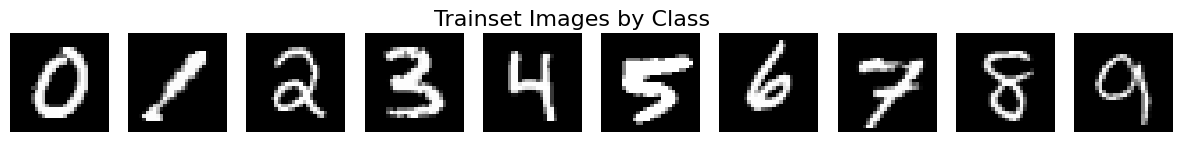

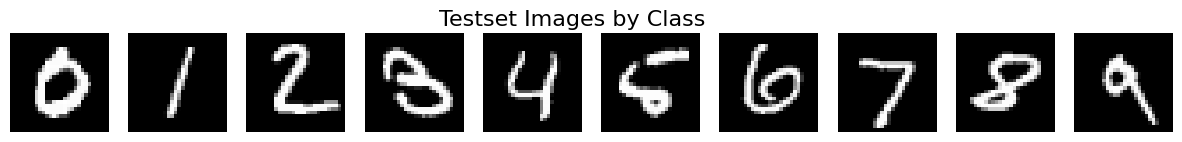

In [21]:
# Going through the dataloader to extract an image per class
def get_images_by_class(dataloader):
    images_by_class = {i: None for i in range(10)}
    for images, labels in dataloader:
        for i in range(len(labels)):
            label = labels[i].item()
            if images_by_class[label] is None:
                images_by_class[label] = images[i]
            if all(v is not None for v in images_by_class.values()):
                return images_by_class
    return images_by_class

def plot_images(images_by_class, title):
    fig, axes = plt.subplots(1, 10, figsize=(15, 1.5))
    fig.suptitle(title, fontsize=16)
    for i in range(10):
        ax = axes[i]
        ax.imshow(images_by_class[i].squeeze(), cmap='gray')
        ax.axis('off')
    plt.show()


train_images = get_images_by_class(train_loader)
test_images = get_images_by_class(test_loader)

plot_images(train_images, "Trainset Images by Class")
plot_images(test_images, "Testset Images by Class")

#### **Verify that the 10 first images are visually different**

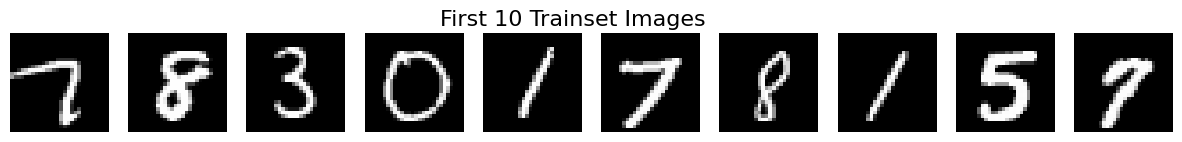

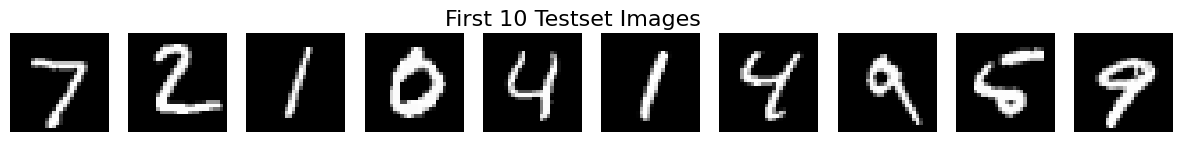

In [22]:
def plot_first_images(dataloader, title, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 1.5))
    fig.suptitle(title, fontsize=16)
    
    images_shown = 0
    for images, labels in dataloader:
        for i in range(len(images)):
            if images_shown >= num_images:
                break
            ax = axes[images_shown]
            ax.imshow(images[i].squeeze(), cmap='gray')
            ax.axis('off')
            images_shown += 1
        if images_shown >= num_images:
            break

    plt.show()

plot_first_images(train_loader, "First 10 Trainset Images")
plot_first_images(test_loader, "First 10 Testset Images")

### **Splitting the dataset into three subsets having each all classes**

In [7]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np

def stratified_split(dataset, proportions):
    class_indices = [np.where(np.array(dataset.targets) == i)[0] for i in range(10)]
    
    split_indices = []
    for proportion in proportions:
        class_split_indices = [np.split(indices, [int(proportion[0]*len(indices)), int((proportion[0]+proportion[1])*len(indices)), int((proportion[0]+proportion[1]+proportion[2])*len(indices))]) for indices in class_indices]
        split_indices.append([np.concatenate([split[i] for split in class_split_indices]) for i in range(4)])
    
    return split_indices

def data_loader():
    transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    # Load the whole MNIST dataset
    full_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    
    # Proportions pour les splits
    proportions = [(0.25, 0.25, 0.25, 0.25)] * 10
    
    # Obtenir les indices pour chaque split
    split_indices = stratified_split(full_trainset, proportions)
    
    # Créer des Subsets
    trainset1 = Subset(full_trainset, split_indices[0][0])
    trainset2 = Subset(full_trainset, split_indices[0][1])
    trainset3 = Subset(full_trainset, split_indices[0][2])
    trainset4 = Subset(full_trainset, split_indices[0][3])

    # Créer des DataLoaders pour chacun des sous-ensembles
    train_loader1 = DataLoader(trainset1, batch_size=train_batch_size, shuffle=True, num_workers=2)
    train_loader2 = DataLoader(trainset2, batch_size=train_batch_size, shuffle=True, num_workers=2)
    train_loader3 = DataLoader(trainset3, batch_size=train_batch_size, shuffle=True, num_workers=2)
    train_loader4 = DataLoader(trainset4, batch_size=train_batch_size, shuffle=True, num_workers=2)

    # Charger le jeu de données de test complet
    testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    test_loader = DataLoader(testset, batch_size=test_batch_size, shuffle=False, num_workers=2)

    return train_loader1, train_loader2, train_loader3, train_loader4, test_loader

# Load DataLoaders
train_loader1, train_loader2, train_loader3, train_loader4, test_loader = data_loader()

# Vérification des tailles des DataLoaders
print(f'Size of train_loader1: {len(train_loader1.dataset)}')
print(f'Size of train_loader2: {len(train_loader2.dataset)}')
print(f'Size of train_loader3: {len(train_loader3.dataset)}')
print(f'Size of train_loader4: {len(train_loader4.dataset)}')
print(f'Size of train_loader: {len(train_loader1.dataset) + len(train_loader2.dataset) + len(train_loader3.dataset) + len(train_loader4.dataset)}')
print(f'Size of test_loader: {len(test_loader.dataset)}')


Size of train_loader1: 14995
Size of train_loader2: 15002
Size of train_loader3: 14998
Size of train_loader4: 15005
Size of train_loader: 60000
Size of test_loader: 10000


### **Verify the content of train_loader subset**

#### **Verify the 10 classes of training dataset and 10 classes of testing dataset**

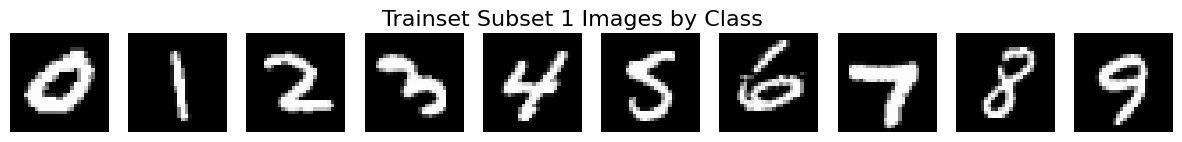

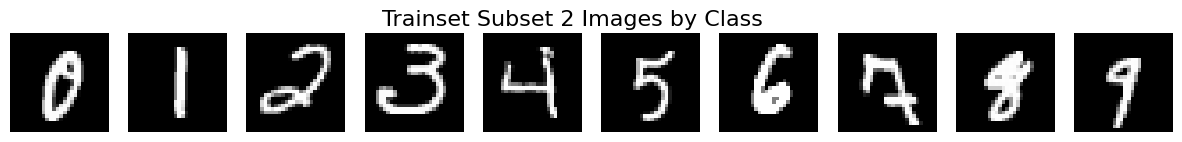

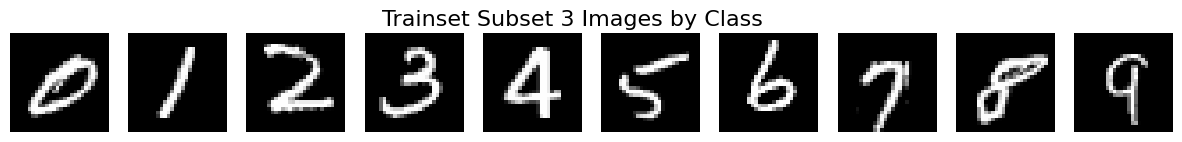

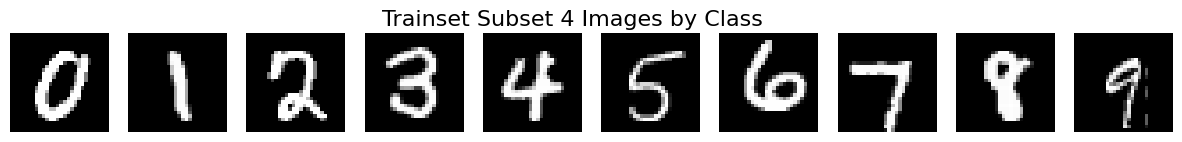

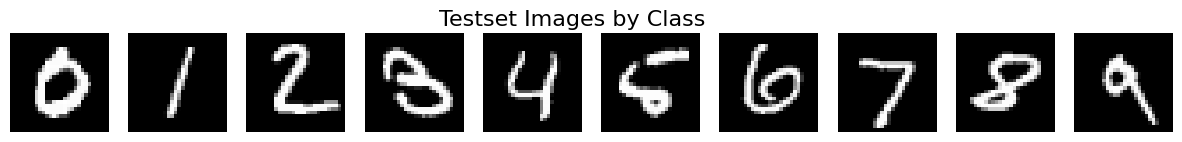

In [23]:
# Going through the dataloader to extract an image per class

train_images1 = get_images_by_class(train_loader1)
train_images2 = get_images_by_class(train_loader2)
train_images3 = get_images_by_class(train_loader3)
train_images4 = get_images_by_class(train_loader4)
test_images = get_images_by_class(test_loader)

plot_images(train_images1, "Trainset Subset 1 Images by Class")
plot_images(train_images2, "Trainset Subset 2 Images by Class")
plot_images(train_images3, "Trainset Subset 3 Images by Class")
plot_images(train_images4, "Trainset Subset 4 Images by Class")
plot_images(test_images, "Testset Images by Class")

#### **Verify that the 10 first images are visually different**

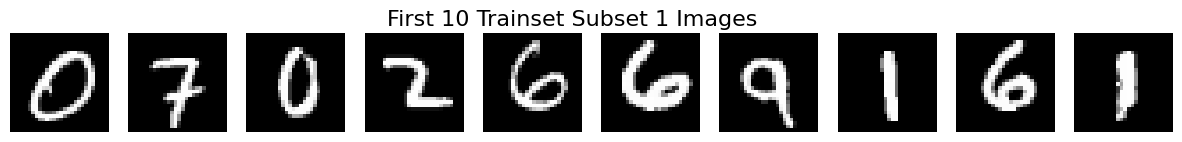

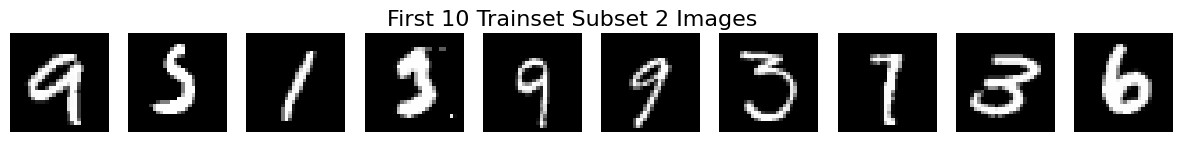

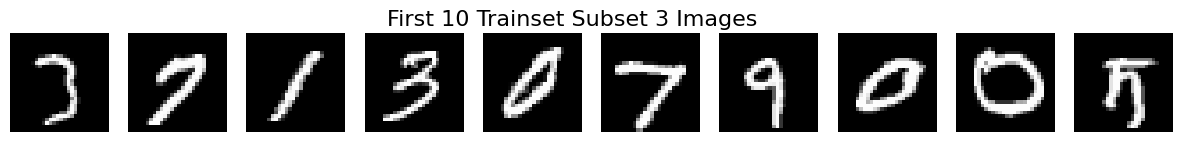

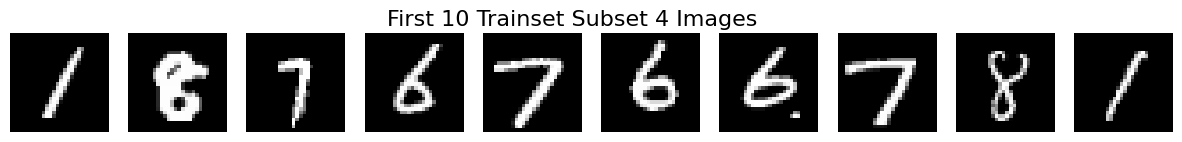

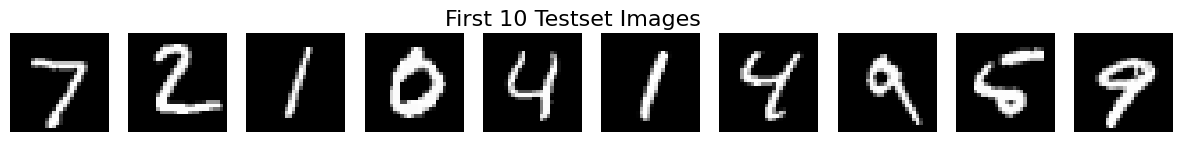

In [24]:
plot_first_images(train_loader1, "First 10 Trainset Subset 1 Images")
plot_first_images(train_loader2, "First 10 Trainset Subset 2 Images")
plot_first_images(train_loader3, "First 10 Trainset Subset 3 Images")
plot_first_images(train_loader4, "First 10 Trainset Subset 4 Images")
plot_first_images(test_loader, "First 10 Testset Images")

### **Defining some variables and creating files & folders**

In [8]:
HDFP = "./volumes/Ultra Touch" # Load HHD

SAVE_LOC = HDFP + "/lobranch-snapshot/diffbitwidth-adaptive-rank/lenet/lobranch"
if not os.path.exists(SAVE_LOC):
    os.makedirs(SAVE_LOC)

SAVE_LOC_OLC = HDFP + "/lobranch-snapshot/diffbitwidth-adaptive-rank/lenet/old-lc"
if not os.path.exists(SAVE_LOC_OLC):
    os.makedirs(SAVE_LOC_OLC)

---

## **First version : LeNet without Incremental Learning**

In [ ]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_for_checkpoint = LeNet()

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model_for_checkpoint = nn.DataParallel(model_for_checkpoint)
    model_for_checkpoint.to(device)
else:
    print("Let's use", torch.cuda.device_count(), "GPU!")
    model_for_checkpoint.to(device)

# Training code
NUM_EPOCHES = 50
learning_rate = 0.02
isLoop = True
optimizer = torch.optim.SGD(model_for_checkpoint.parameters(), lr=learning_rate)

# Initialize a new W&B run
wandb.init(project="LeNet", 
           name="LeNet-Without-Incremental-Learning", 
           tags=["LeNet", "Without-Incremental-Learning", "MNIST"],
           config={"num_epoches": NUM_EPOCHES,
                    "model": "LeNet",
                    "train dataset": "CIFAR10 train dataset[:]",
                    "test dataset": "CIFAR10 test dataset[:]",
                    "batch_size on training": train_batch_size,
                    "batch_size on testing": test_batch_size,
                    "num_workers": num_work,
                    "learning_rate": learning_rate,
                    "optimizer": "SGD",
                }
           )



print("Start of model training...")
for epoch in range(NUM_EPOCHES):
    if not isLoop:
        break
    else:
        train_loss = 0.0
        valid_loss = 0.0

        train_correct = 0
        train_total = 0

        valid_correct = 0
        valid_total = 0
        
        model_for_checkpoint.train()
        for iter, data in enumerate(train_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            output = model_for_checkpoint(inputs)

            loss = torch.nn.CrossEntropyLoss()(output, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(output, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

            train_acc = torch.eq(output.argmax(-1), labels).float().mean()

        model_for_checkpoint.eval()
        with torch.no_grad():  # Gradient computation is not needed for validation
            for data, target in test_loader:
                # Move data and target to the correct device
                data, target = data.to(device), target.to(device)

                output = model_for_checkpoint(data)
                loss = torch.nn.CrossEntropyLoss()(output, target)
                valid_loss += loss.item() * data.size(0)

                _, predicted = torch.max(output, 1)
                valid_correct += (predicted == target).sum().item()
                valid_total += target.size(0)

                valid_acc = torch.eq(output.argmax(-1), target).float().mean()


    # Calculate average losses
    train_loss /= len(train_loader.dataset)
    valid_loss /= len(test_loader.dataset)

    train_accuarcy = train_correct / train_total
    valid_accuracy = valid_correct / valid_total

    print("Epoch: [{}/{}], Training Loss: {:.6f}, Validation Loss: {:.6f}, Training Accuracy: {:.6f}, Validation Accuracy: {:.6f}".format(epoch, NUM_EPOCHES-1, train_loss, valid_loss, train_accuarcy, valid_accuracy))

    wandb.log({
        "train_loss": train_loss,
        "valid_loss": valid_loss,
        "train_accuracy": train_accuarcy,
        "valid_accuracy": valid_accuracy
    })


print("End of model training...")

# Finish the wandb run
wandb.finish()

---

## **Second version : LeNet with Incremental Learning**

##### **Training on trainloader1**

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_with_incremental_learning = LeNet()

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model_with_incremental_learning = nn.DataParallel(model_with_incremental_learning)
    model_with_incremental_learning.to(device)
else:
    print("Let's use", torch.cuda.device_count(), "GPU!")
    model_with_incremental_learning.to(device)

# Training code
NUM_EPOCHES = 45
learning_rate = 0.01
isLoop = True
optimizer = torch.optim.SGD(model_with_incremental_learning.parameters(), lr=learning_rate)

# Initialize a new W&B run
wandb.init(project="LeNet", 
           name="LeNet-With-Incremental-Learning", 
           tags=["LeNet", "With-Incremental-Learning", "MNIST"],
           config={"num_epoches": NUM_EPOCHES,
                    "model": "LeNet",
                    "train dataset": "CIFAR10 train dataloader1",
                    "test dataset": "CIFAR10 test dataset[:]",
                    "batch_size on training": train_batch_size,
                    "batch_size on testing": test_batch_size,
                    "num_workers": num_work,
                    "learning_rate": learning_rate,
                    "optimizer": "SGD",
                }
           )



print("Start of model training on dataloader1...")
for epoch in range(NUM_EPOCHES):
    if not isLoop:
        break
    else:
        train_loss = 0.0
        valid_loss = 0.0

        train_correct = 0
        train_total = 0

        valid_correct = 0
        valid_total = 0
        
        model_with_incremental_learning.train()
        for iter, data in enumerate(train_loader1):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            output = model_with_incremental_learning(inputs)

            loss = torch.nn.CrossEntropyLoss()(output, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(output, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

            train_acc = torch.eq(output.argmax(-1), labels).float().mean()

        model_with_incremental_learning.eval()
        with torch.no_grad():  # Gradient computation is not needed for validation
            for data, target in test_loader:
                # Move data and target to the correct device
                data, target = data.to(device), target.to(device)

                output = model_with_incremental_learning(data)
                loss = torch.nn.CrossEntropyLoss()(output, target)
                valid_loss += loss.item() * data.size(0)

                _, predicted = torch.max(output, 1)
                valid_correct += (predicted == target).sum().item()
                valid_total += target.size(0)

                valid_acc = torch.eq(output.argmax(-1), target).float().mean()


    # Calculate average losses
    train_loss /= len(train_loader1.dataset)
    valid_loss /= len(test_loader.dataset)

    train_accuarcy = train_correct / train_total
    valid_accuracy = valid_correct / valid_total

    print("Epoch: [{}/{}], Training Loss: {:.6f}, Validation Loss: {:.6f}, Training Accuracy: {:.6f}, Validation Accuracy: {:.6f}".format(epoch, NUM_EPOCHES-1, train_loss, valid_loss, train_accuarcy, valid_accuracy))

    wandb.log({
        "train_loss": train_loss,
        "valid_loss": valid_loss,
        "train_accuracy": train_accuarcy,
        "valid_accuracy": valid_accuracy,
        "epoch": epoch
    })


print("End of model training on dataloader1...")

##### **Training on trainloader2**

In [ ]:

print("-----------------------------------")

# Training code on dataloader2
print("Start of model training on dataloader2...")

for epoch in range(NUM_EPOCHES):
    if not isLoop:
        break
    else:
        train_loss = 0.0
        valid_loss = 0.0

        train_correct = 0
        train_total = 0

        valid_correct = 0
        valid_total = 0
        
        model_with_incremental_learning.train()
        for iter, data in enumerate(train_loader2):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            output = model_with_incremental_learning(inputs)

            loss = torch.nn.CrossEntropyLoss()(output, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(output, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

            train_acc = torch.eq(output.argmax(-1), labels).float().mean()

        model_with_incremental_learning.eval()
        with torch.no_grad():  # Gradient computation is not needed for validation
            for data, target in test_loader:
                # Move data and target to the correct device
                data, target = data.to(device), target.to(device)

                output = model_with_incremental_learning(data)
                loss = torch.nn.CrossEntropyLoss()(output, target)
                valid_loss += loss.item() * data.size(0)

                _, predicted = torch.max(output, 1)
                valid_correct += (predicted == target).sum().item()
                valid_total += target.size(0)

                valid_acc = torch.eq(output.argmax(-1), target).float().mean()


    # Calculate average losses
    train_loss /= len(train_loader2.dataset)
    valid_loss /= len(test_loader.dataset)

    train_accuarcy = train_correct / train_total
    valid_accuracy = valid_correct / valid_total

    print("Epoch: [{}/{}], Training Loss: {:.6f}, Validation Loss: {:.6f}, Training Accuracy: {:.6f}, Validation Accuracy: {:.6f}".format(epoch, NUM_EPOCHES-1, train_loss, valid_loss, train_accuarcy, valid_accuracy))

    wandb.log({
        "train_loss": train_loss,
        "valid_loss": valid_loss,
        "train_accuracy": train_accuarcy,
        "valid_accuracy": valid_accuracy,
        "epoch": epoch
    })


print("End of model training on dataloader2...")

##### **Training on trainloader3**

In [ ]:

print("-----------------------------------")

# Training code on dataloader2
print("Start of model training on dataloader3...")

for epoch in range(NUM_EPOCHES):
    if not isLoop:
        break
    else:
        train_loss = 0.0
        valid_loss = 0.0

        train_correct = 0
        train_total = 0

        valid_correct = 0
        valid_total = 0
        
        model_with_incremental_learning.train()
        for iter, data in enumerate(train_loader3):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            output = model_with_incremental_learning(inputs)

            loss = torch.nn.CrossEntropyLoss()(output, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(output, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

            train_acc = torch.eq(output.argmax(-1), labels).float().mean()

        model_with_incremental_learning.eval()
        with torch.no_grad():  # Gradient computation is not needed for validation
            for data, target in test_loader:
                # Move data and target to the correct device
                data, target = data.to(device), target.to(device)

                output = model_with_incremental_learning(data)
                loss = torch.nn.CrossEntropyLoss()(output, target)
                valid_loss += loss.item() * data.size(0)

                _, predicted = torch.max(output, 1)
                valid_correct += (predicted == target).sum().item()
                valid_total += target.size(0)

                valid_acc = torch.eq(output.argmax(-1), target).float().mean()


    # Calculate average losses
    train_loss /= len(train_loader3.dataset)
    valid_loss /= len(test_loader.dataset)

    train_accuarcy = train_correct / train_total
    valid_accuracy = valid_correct / valid_total

    print("Epoch: [{}/{}], Training Loss: {:.6f}, Validation Loss: {:.6f}, Training Accuracy: {:.6f}, Validation Accuracy: {:.6f}".format(epoch, NUM_EPOCHES-1, train_loss, valid_loss, train_accuarcy, valid_accuracy))

    wandb.log({
        "train_loss": train_loss,
        "valid_loss": valid_loss,
        "train_accuracy": train_accuarcy,
        "valid_accuracy": valid_accuracy,
        "epoch": epoch
    })


print("End of model training on dataloader3...")
# Finish the wandb run
wandb.finish()

---

## **Third version : LeNet with Incremental Learning, LC-checkpoint, and Delta-LoRA**

##### **Training on trainloader1**

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_with_incremental_learning_lc_dlora = LeNet()

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model_with_incremental_learning_lc_dlora = nn.DataParallel(model_with_incremental_learning_lc_dlora)
    model_with_incremental_learning_lc_dlora.to(device)
else:
    print("Let's use", torch.cuda.device_count(), "GPU!")
    model_with_incremental_learning_lc_dlora.to(device)

# Training code
NUM_EPOCHES = 30
learning_rate = 0.1
learning_rate_dloralc = 0.1
learning_rate1 = 0.005
# super_step = len(train_loader2)
# super_step = 20
isLoop = True

optimizer = torch.optim.SGD(model_with_incremental_learning_lc_dlora.parameters(), lr=learning_rate1)

# Initialize a new W&B run
wandb.init(project="LeNet", 
           name="LeNet-With-Incremental-Learning_LC_DLORA-Without-Restore_25_25_25_25", 
           tags=["LeNet", "With-Incremental-Learning_LC_DLORA", "MNIST"],
           config={"num_epoches": NUM_EPOCHES,
                    "model": "LeNet",
                    "splitting": "25-25-25-25",
                    "train dataset 1": "MNIST train dataloader1",
                    "test dataset": "MNIST test dataset[:]",
                    "batch_size on training": train_batch_size,
                    "batch_size on testing": test_batch_size,
                    "num_workers": num_work,
                    "learning_rate_nothing": learning_rate,
                    "learning_rate_dloralc": learning_rate_dloralc,
                    "optimizer": "SGD"
                }
           )

print("Start of model training on dataloader1...")
for epoch in range(NUM_EPOCHES):
    if not isLoop:
        break
    else:
        train_loss = 0.0
        valid_loss = 0.0

        train_correct = 0
        train_total = 0

        valid_correct = 0
        valid_total = 0
        
        model_with_incremental_learning_lc_dlora.train()
        for iter, data in enumerate(train_loader1):

            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            output = model_with_incremental_learning_lc_dlora(inputs)

            loss = torch.nn.CrossEntropyLoss()(output, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss * inputs.size(0)

            _, predicted = torch.max(output, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

            train_acc = torch.eq(output.argmax(-1), labels).float().mean()

        model_with_incremental_learning_lc_dlora.eval()
        with torch.no_grad():  # Gradient computation is not needed for validation
            for data, target in test_loader:
                # Move data and target to the correct device
                data, target = data.to(device), target.to(device)

                output = model_with_incremental_learning_lc_dlora(data)
                loss = torch.nn.CrossEntropyLoss()(output, target)
                valid_loss += loss.item() * data.size(0)

                _, predicted = torch.max(output, 1)
                valid_correct += (predicted == target).sum().item()
                valid_total += target.size(0)

                valid_acc = torch.eq(output.argmax(-1), target).float().mean()

    # Calculate average losses
    train_loss /= len(train_loader1.dataset)
    valid_loss /= len(test_loader.dataset)

    train_accuarcy = train_correct / train_total
    valid_accuracy = valid_correct / valid_total

    if valid_accuracy > 0.7:
        rounded_valid_acc = round(valid_accuracy, 4)
        # torch.save(model_for_checkpoint.state_dict(), HDFP + "/lobranch-snapshot/branchpoints/vit/branch_{}.pt".format(rounded_valid_acc))
        torch.save(model_with_incremental_learning_lc_dlora.state_dict(), HDFP + "/lobranch-snapshot/branchpoints/lenet/branch_{}.pt".format(rounded_valid_acc))
        print("Model saved at accuracy: {:.4f}".format(rounded_valid_acc))
        isLoop = False
        break
    # if valid_accuracy > 0.90:
    #     isLoop = False
    #     break

    print("Epoch: [{}/{}], Training Loss: {:.6f}, Validation Loss: {:.6f}, Training Accuracy: {:.6f}, Validation Accuracy: {:.6f}".format(epoch, NUM_EPOCHES-1, train_loss, valid_loss, train_accuarcy, valid_accuracy))

    wandb.log({
        "train_loss_dloralc": train_loss,
        "valid_loss_dloralc": valid_loss,
        "train_accuracy_dloralc": train_accuarcy,
        "valid_accuracy_dloralc": valid_accuracy,
        "train_loss_lc": train_loss,
        "valid_loss_lc": valid_loss,
        "train_accuracy_lc": train_accuarcy,
        "valid_accuracy_lc": valid_accuracy, 
        "train_loss": train_loss,
        "valid_loss": valid_loss,
        "train_accuracy": train_accuarcy,
        "valid_accuracy": valid_accuracy,
        "epoch": epoch,
    })
    # wandb.log({
    #     "train_loss_dloralc": train_loss,
    #     "valid_loss_dloralc": valid_loss,
    #     "train_accuracy_dloralc": train_accuarcy,
    #     "valid_accuracy_dloralc": valid_accuracy,
    #     "train_loss_lc": train_loss,
    #     "valid_loss_lc": valid_loss,
    #     "train_accuracy_lc": train_accuarcy,
    #     "valid_accuracy_lc": valid_accuracy, 
    #     "train_loss": train_loss,
    #     "valid_loss": valid_loss,
    #     "train_accuracy": train_accuarcy,
    #     "valid_accuracy": valid_accuracy,
    #     "valid_loss_dloralc_restored": valid_loss,
    #     "valid_accuracy_dloralc_restored": valid_accuracy,
    #     "epoch": epoch,
    # })

print("End of model training on dataloader1...")

Let's use 1 GPU!


Start of model training on dataloader1...
Epoch: [0/29], Training Loss: 2.263898, Validation Loss: 2.211693, Training Accuracy: 0.247016, Validation Accuracy: 0.452200
Epoch: [1/29], Training Loss: 2.111947, Validation Loss: 1.965460, Training Accuracy: 0.541380, Validation Accuracy: 0.571200
Epoch: [2/29], Training Loss: 1.775779, Validation Loss: 1.560456, Training Accuracy: 0.561387, Validation Accuracy: 0.603400
Model saved at accuracy: 0.7024
End of model training on dataloader1...


### **Working on training with delta-LoRA and LC-checkpoint on dataloader2** 

In [10]:
DECOMPOSED_LAYERS = ["classifier.1.weight", "classifier.3.weight"]
RANK = -1
SCALING = -1
BRANCH_ACC = "0.7024"

In [11]:
original = LeNet().to(device)
model_original = LeNet().to(device)
model_no_touch = LeNet().to(device)

In [12]:
BRANCH_LOC = HDFP + "/lobranch-snapshot/branchpoints/lenet/branch_{}.pt".format(BRANCH_ACC)
original.load_state_dict(torch.load(BRANCH_LOC))
model_original.load_state_dict(torch.load(BRANCH_LOC))
model_no_touch.load_state_dict(torch.load(BRANCH_LOC))

<All keys matched successfully>

In [13]:
w, b = getBase(original)
model = LeNet_LowRank(w, b, rank = RANK).to(device)

In [14]:
print(model.state_dict().keys())

odict_keys(['feature.0.weight', 'feature.0.bias', 'feature.3.weight', 'feature.3.bias', 'classifier.1.alpha', 'classifier.1.beta', 'classifier.1.bias', 'classifier.3.alpha', 'classifier.3.beta', 'classifier.3.bias', 'classifier.5.weight', 'classifier.5.bias'])


In [15]:
load_sd_decomp(torch.load(BRANCH_LOC, map_location=device), model, DECOMPOSED_LAYERS)

In [16]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate_dloralc)
optimizer_lc_only = torch.optim.SGD(model_original.parameters(), lr=learning_rate)
optimizer_no_touch = torch.optim.SGD(model_no_touch.parameters(), lr=learning_rate)

In [17]:
full_accuracy = []
decomposed_full_accuracy = []
restored_accuracy = []
lc_accuracy = []

# Initialize the current iteration and set to 0
current_iter = 0
current_set = 0

# Initialize the current iteration and set to 0 for the old LC method
current_iter_old_lc = 0
current_set_old_lc = 0


acc = lambda x, y : (torch.max(x, 1)[1] == y).sum().item() / y.size(0)


### **Without Restored Model DeltaLoRA + LC**

In [18]:
print("-----------------------------------")

wandb.config["branch_accuracy"] = BRANCH_ACC
wandb.config["train dataset 2"] = "MNIST train dataloader2"

# Training code on dataloader2
print("Start of model training on dataloader2...")

isLoop = True

valid_accuracy_list = []

base = None

for epoch in range(NUM_EPOCHES):
    if not isLoop:
        break
    else:
        train_loss = 0.0
        train_loss_lc = 0.0
        train_loss_no_touch = 0.0
        valid_loss = 0.0
        valid_loss_lc = 0.0
        valid_loss_no_touch = 0.0

        train_correct = 0
        train_correct_lc = 0
        train_correct_no_touch = 0
        train_total = 0
        train_total_lc = 0
        train_total_no_touch = 0

        valid_correct = 0
        valid_correct_lc = 0
        valid_correct_no_touch = 0
        valid_total = 0
        valid_total_lc = 0
        valid_total_no_touch = 0
        
        model.train()
        model_original.train()
        model_no_touch.train()

        for iter, data in enumerate(train_loader2):

            # Check if it is the first iteration of the first epoch
            if iter == 0: # first iteration, create baseline model
            # if iter == 0 and epoch == 0: # first iteration, create baseline model
                ########################################################
                ### DELTA-LORA + LC
                ########################################################
                
                base, base_decomp = lc.extract_weights_gpu(model, SAVE_LOC + 
                                                        "/set_{}".format(current_set), DECOMPOSED_LAYERS)

                ########################################################
                ### LC
                ########################################################

                cstate = model_original.state_dict()
                set_path = "/set_{}".format(current_set_old_lc)
                if not os.path.exists(SAVE_LOC_OLC + set_path):
                    os.makedirs(SAVE_LOC_OLC + set_path)
                prev_state = olc.extract_weights_gpu(cstate, SAVE_LOC_OLC + set_path,DECOMPOSED_LAYERS)
            
            else:
                
                ########################################################
                ### DELTA-LORA + LC 
                ########################################################

                # Delta-compression: The delta for the weights of the normal and decomposed layers.
                # Also returns the full dictionary, which holds the bias.

                #Calculate the time before generate_delta_gpu function
                delta, decomp_delta, bias = lc.generate_delta_gpu(base, 
                                                                base_decomp, model.state_dict(), DECOMPOSED_LAYERS)
                # Compressing the delta and decomposed delta
                compressed_delta, full_delta, compressed_dcomp_delta, full_dcomp_delta  = lc.compress_delta(delta, 
                                                                                                            decomp_delta)
                # Saving checkpoint
                # lc.save_checkpoint(compressed_delta, compressed_dcomp_delta, bias, current_iter, SAVE_LOC + 
                #                 "/set_{}".format(current_set))
            
                # Update base and base_decomp
                base = np.add(base, full_delta) # Replace base with latest for delta to accumulate.
                base_decomp = np.add(full_dcomp_delta, base_decomp)

                # Update current iteration
                current_iter += 1

                ########################################################
                ### LC
                ########################################################

                cstate = model_original.state_dict()
                old_lc_delta, old_lc_bias = olc.generate_delta_gpu(prev_state, cstate, DECOMPOSED_LAYERS)
                olc_compressed_delta, update_prev = olc.compress_data(old_lc_delta, num_bits = 3)
                # olc.save_checkpoint(SAVE_LOC_OLC + "/set_{}".format(current_set_old_lc), olc_compressed_delta, 
                #                     old_lc_bias, current_iter_old_lc)
                prev_state = np.add(prev_state, update_prev)
                current_iter_old_lc += 1

            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            ########################################################
            ### DELTA-LORA + LC
            ########################################################

            optimizer.zero_grad()
            output = model(inputs)

            loss = torch.nn.CrossEntropyLoss()(output, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(output, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

            train_acc = torch.eq(output.argmax(-1), labels).float().mean()

            ########################################################
            ### LC
            ########################################################

            optimizer_lc_only.zero_grad()
            output_lc = model_original(inputs)

            loss_lc = torch.nn.CrossEntropyLoss()(output_lc, labels)
            loss_lc.backward()
            optimizer_lc_only.step()
            train_loss_lc += loss_lc.item() * inputs.size(0)

            _, predicted_lc = torch.max(output_lc, 1)
            train_correct_lc += (predicted_lc == labels).sum().item()
            train_total_lc += labels.size(0)

            train_acc_lc = torch.eq(output_lc.argmax(-1), labels).float().mean()

            ########################################################
            ### NO TOUCH
            ########################################################

            optimizer_no_touch.zero_grad()
            output_no_touch = model_no_touch(inputs)

            loss_no_touch = torch.nn.CrossEntropyLoss()(output_no_touch, labels)
            loss_no_touch.backward()
            optimizer_no_touch.step()
            train_loss_no_touch += loss_no_touch.item() * inputs.size(0)

            _, predicted_no_touch = torch.max(output_no_touch, 1)
            train_correct_no_touch += (predicted_no_touch == labels).sum().item()
            train_total_no_touch += labels.size(0)

            train_acc_no_touch = torch.eq(output_no_touch.argmax(-1), labels).float().mean()

        model.eval()
        model_original.eval()
        model_no_touch.eval()
        with torch.no_grad():  # Gradient computation is not needed for validation
            for data, target in test_loader:
                # Move data and target to the correct device
                data, target = data.to(device), target.to(device)

                ########################################################
                ### DELTA-LORA + LC
                ########################################################

                output = model(data)
                loss = torch.nn.CrossEntropyLoss()(output, target)
                valid_loss += loss.item() * data.size(0)

                _, predicted = torch.max(output, 1)
                valid_correct += (predicted == target).sum().item()
                valid_total += target.size(0)

                valid_acc = torch.eq(output.argmax(-1), target).float().mean()

                ########################################################
                ### LC
                ########################################################

                output_lc = model_original(data)
                loss_lc = torch.nn.CrossEntropyLoss()(output_lc, target)
                valid_loss_lc += loss_lc.item() * data.size(0)

                _, predicted_lc = torch.max(output_lc, 1)
                valid_correct_lc += (predicted_lc == target).sum().item()
                valid_total_lc += target.size(0)

                valid_acc_lc = torch.eq(output_lc.argmax(-1), target).float().mean()

                ########################################################
                ### NO TOUCH
                ########################################################

                output_no_touch = model_no_touch(data)
                loss_no_touch = torch.nn.CrossEntropyLoss()(output_no_touch, target)
                valid_loss_no_touch += loss_no_touch.item() * data.size(0)

                _, predicted_no_touch = torch.max(output_no_touch, 1)
                valid_correct_no_touch += (predicted_no_touch == target).sum().item()
                valid_total_no_touch += target.size(0)

                valid_acc_no_touch = torch.eq(output_no_touch.argmax(-1), target).float().mean()

                
    # Calculate average losses
    train_loss /= len(train_loader2.dataset)
    train_loss_lc /= len(train_loader2.dataset)
    train_loss_no_touch /= len(train_loader2.dataset)
    valid_loss /= len(test_loader.dataset)
    valid_loss_lc /= len(test_loader.dataset)
    valid_loss_no_touch /= len(test_loader.dataset)

    train_accuarcy = train_correct / train_total
    train_accuarcy_lc = train_correct_lc / train_total_lc
    train_accuarcy_no_touch = train_correct_no_touch / train_total_no_touch
    valid_accuracy = valid_correct / valid_total
    valid_accuracy_lc = valid_correct_lc / valid_total_lc
    valid_accuracy_no_touch = valid_correct_no_touch / valid_total_no_touch

    valid_accuracy_list.append(valid_accuracy)
    
    print("Epoch: [{}/{}], Training Loss DLoRALC: {:.6f}, Validation Loss DLoRALC: {:.6f}, Training Accuracy DLoRALC: {:.6f}, Validation Accuracy DLoRALC: {:.6f} \n \
          \t Training Loss LC: {:.6f}, Validation Loss LC: {:.6f}, Training Accuracy LC: {:.6f}, Validation Accuracy LC: {:.6f}, \n \
          \t Training Loss: {:.6f}, Validation Loss: {:.6f}, Training Accuracy: {:.6f}, Validation Accuracy: {:.6f}".format(epoch, NUM_EPOCHES-1, 
        train_loss, valid_loss, train_accuarcy, valid_accuracy, 
        train_loss_lc, valid_loss_lc, train_accuarcy_lc, valid_accuracy_lc, 
        train_loss_no_touch, valid_loss_no_touch, train_accuarcy_no_touch, valid_accuracy_no_touch)) 

    wandb.log({
        "train_loss_dloralc": train_loss,
        "valid_loss_dloralc": valid_loss,
        "train_accuracy_dloralc": train_accuarcy,
        "valid_accuracy_dloralc": valid_accuracy,
        "train_loss_lc": train_loss_lc,
        "valid_loss_lc": valid_loss_lc,
        "train_accuracy_lc": train_accuarcy_lc,
        "valid_accuracy_lc": valid_accuracy_lc,
        "train_loss": train_loss_no_touch,
        "valid_loss": valid_loss_no_touch,
        "train_accuracy": train_accuarcy_no_touch,
        "valid_accuracy": valid_accuracy_no_touch,
        "epoch": epoch
    })


print("End of model training on dataloader2...")

-----------------------------------
Start of model training on dataloader2...
Epoch: [0/29], Training Loss DLoRALC: 0.677365, Validation Loss DLoRALC: 0.420171, Training Accuracy DLoRALC: 0.817558, Validation Accuracy DLoRALC: 0.887400 
           	 Training Loss LC: 0.493658, Validation Loss LC: 0.282517, Training Accuracy LC: 0.866418, Validation Accuracy LC: 0.916400, 
           	 Training Loss: 0.493658, Validation Loss: 0.282517, Training Accuracy: 0.866418, Validation Accuracy: 0.916400
Epoch: [1/29], Training Loss DLoRALC: 0.344794, Validation Loss DLoRALC: 0.272843, Training Accuracy DLoRALC: 0.907346, Validation Accuracy DLoRALC: 0.923800 
           	 Training Loss LC: 0.223026, Validation Loss LC: 0.175088, Training Accuracy LC: 0.935009, Validation Accuracy LC: 0.947400, 
           	 Training Loss: 0.223026, Validation Loss: 0.175088, Training Accuracy: 0.935009, Validation Accuracy: 0.947400
Epoch: [2/29], Training Loss DLoRALC: 0.226232, Validation Loss DLoRALC: 0.20269

### **With Restored Model DeltaLoRA + LC**

#### **Without Super Step**

In [ ]:

# print("-----------------------------------")

# wandb.config["branch_accuracy"] = BRANCH_ACC

# # Training code on dataloader2
# print("Start of model training on dataloader2...")

# isLoop = True

# valid_accuracy_list = []

# base = None

# for epoch in range(NUM_EPOCHES):
#     if not isLoop:
#         break
#     else:
#         train_loss = 0.0
#         train_loss_lc = 0.0
#         train_loss_no_touch = 0.0
#         valid_loss = 0.0
#         valid_loss_lc = 0.0
#         valid_loss_no_touch = 0.0
#         valid_loss_dlora_lc_restored = 0.0

#         train_correct = 0
#         train_correct_lc = 0
#         train_correct_no_touch = 0
#         train_total = 0
#         train_total_lc = 0
#         train_total_no_touch = 0

#         valid_correct = 0
#         valid_correct_lc = 0
#         valid_correct_no_touch = 0
#         valid_correct_dlora_lc_restored = 0
#         valid_total = 0
#         valid_total_lc = 0
#         valid_total_no_touch = 0
#         valid_total_dlora_lc_restored = 0
        
#         model.train()
#         model_original.train()
#         model_no_touch.train()

#         for iter, data in enumerate(train_loader2):

#             # Check if it is the first iteration of the first epoch
#             if iter == 0 and epoch == 0: # first iteration, create baseline model
#                 ########################################################
#                 ### DELTA-LORA + LC
#                 ########################################################
                
#                 base, base_decomp = lc.extract_weights_gpu(model, SAVE_LOC + 
#                                                         "/set_{}".format(current_set), DECOMPOSED_LAYERS)

#                 ########################################################
#                 ### LC
#                 ########################################################

#                 cstate = model_original.state_dict()
#                 set_path = "/set_{}".format(current_set_old_lc)
#                 if not os.path.exists(SAVE_LOC_OLC + set_path):
#                     os.makedirs(SAVE_LOC_OLC + set_path)
#                 prev_state = olc.extract_weights_gpu(cstate, SAVE_LOC_OLC + set_path,DECOMPOSED_LAYERS)
            
#             else:
#                 ########################################################
#                 ### DELTA-LORA + LC 
#                 ########################################################

#                 # Delta-compression: The delta for the weights of the normal and decomposed layers.
#                 # Also returns the full dictionary, which holds the bias.

#                 #Calculate the time before generate_delta_gpu function
#                 delta, decomp_delta, bias = lc.generate_delta_gpu(base, 
#                                                                 base_decomp, model.state_dict(), DECOMPOSED_LAYERS)
#                 # Compressing the delta and decomposed delta
#                 compressed_delta, full_delta, compressed_dcomp_delta, full_dcomp_delta  = lc.compress_delta(delta, 
#                                                                                                             decomp_delta)
#                 # Saving checkpoint
#                 lc.save_checkpoint(compressed_delta, compressed_dcomp_delta, bias, current_iter, SAVE_LOC + 
#                                 "/set_{}".format(current_set))
            
#                 # Update base and base_decomp
#                 base = np.add(base, full_delta) # Replace base with latest for delta to accumulate.
#                 base_decomp = np.add(full_dcomp_delta, base_decomp)

#                 # Update current iteration
#                 current_iter += 1

#                 ########################################################
#                 ### LC
#                 ########################################################

#                 cstate = model_original.state_dict()
#                 old_lc_delta, old_lc_bias = olc.generate_delta_gpu(prev_state, cstate, DECOMPOSED_LAYERS)
#                 olc_compressed_delta, update_prev = olc.compress_data(old_lc_delta, num_bits = 3)
#                 olc.save_checkpoint(SAVE_LOC_OLC + "/set_{}".format(current_set_old_lc), olc_compressed_delta, 
#                                     old_lc_bias, current_iter_old_lc)
#                 prev_state = np.add(prev_state, update_prev)
#                 current_iter_old_lc += 1



#             inputs, labels = data
#             inputs, labels = inputs.to(device), labels.to(device)

#             ########################################################
#             ### DELTA-LORA + LC
#             ########################################################

#             optimizer.zero_grad()
#             output = model(inputs)

#             loss = torch.nn.CrossEntropyLoss()(output, labels)
#             loss.backward()
#             optimizer.step()
#             train_loss += loss.item() * inputs.size(0)

#             _, predicted = torch.max(output, 1)
#             train_correct += (predicted == labels).sum().item()
#             train_total += labels.size(0)

#             train_acc = torch.eq(output.argmax(-1), labels).float().mean()

#             ########################################################
#             ### LC
#             ########################################################

#             optimizer_lc_only.zero_grad()
#             output_lc = model_original(inputs)

#             loss_lc = torch.nn.CrossEntropyLoss()(output_lc, labels)
#             loss_lc.backward()
#             optimizer_lc_only.step()
#             train_loss_lc += loss_lc.item() * inputs.size(0)

#             _, predicted_lc = torch.max(output_lc, 1)
#             train_correct_lc += (predicted_lc == labels).sum().item()
#             train_total_lc += labels.size(0)

#             train_acc_lc = torch.eq(output_lc.argmax(-1), labels).float().mean()

#             ########################################################
#             ### NO TOUCH
#             ########################################################

#             optimizer_no_touch.zero_grad()
#             output_no_touch = model_no_touch(inputs)

#             loss_no_touch = torch.nn.CrossEntropyLoss()(output_no_touch, labels)
#             loss_no_touch.backward()
#             optimizer_no_touch.step()
#             train_loss_no_touch += loss_no_touch.item() * inputs.size(0)

#             _, predicted_no_touch = torch.max(output_no_touch, 1)
#             train_correct_no_touch += (predicted_no_touch == labels).sum().item()
#             train_total_no_touch += labels.size(0)

#             train_acc_no_touch = torch.eq(output_no_touch.argmax(-1), labels).float().mean()

#         model.eval()
#         model_original.eval()
#         model_no_touch.eval()
#         with torch.no_grad():  # Gradient computation is not needed for validation
#             for data, target in test_loader:
#                 # Move data and target to the correct device
#                 data, target = data.to(device), target.to(device)

#                 ########################################################
#                 ### DELTA-LORA + LC
#                 ########################################################

#                 output = model(data)
#                 loss = torch.nn.CrossEntropyLoss()(output, target)
#                 valid_loss += loss.item() * data.size(0)

#                 _, predicted = torch.max(output, 1)
#                 valid_correct += (predicted == target).sum().item()
#                 valid_total += target.size(0)

#                 valid_acc = torch.eq(output.argmax(-1), target).float().mean()

#                 ########################################################
#                 ### LC
#                 ########################################################

#                 output_lc = model_original(data)
#                 loss_lc = torch.nn.CrossEntropyLoss()(output_lc, target)
#                 valid_loss_lc += loss_lc.item() * data.size(0)

#                 _, predicted_lc = torch.max(output_lc, 1)
#                 valid_correct_lc += (predicted_lc == target).sum().item()
#                 valid_total_lc += target.size(0)

#                 valid_acc_lc = torch.eq(output_lc.argmax(-1), target).float().mean()

#                 ########################################################
#                 ### NO TOUCH
#                 ########################################################

#                 output_no_touch = model_no_touch(data)
#                 loss_no_touch = torch.nn.CrossEntropyLoss()(output_no_touch, target)
#                 valid_loss_no_touch += loss_no_touch.item() * data.size(0)

#                 _, predicted_no_touch = torch.max(output_no_touch, 1)
#                 valid_correct_no_touch += (predicted_no_touch == target).sum().item()
#                 valid_total_no_touch += target.size(0)

#                 valid_acc_no_touch = torch.eq(output_no_touch.argmax(-1), target).float().mean()

#                 ########################################################
#                 ### DELTA-LORA + LC (restored)
#                 ########################################################
#                 folder = SAVE_LOC + "/set_{}".format(current_set)
#                 # print(folder)
#                 num_files = len([f for f in os.listdir(folder)if os.path.isfile(os.path.join(folder, f))])
#                 # print(num_files)
#                 restored_model = lc.restore_checkpoint(original, LeNet(), SAVE_LOC, 0, num_files-3 , DECOMPOSED_LAYERS)

#                 # restored_model = lazy_restore_gpu(base, base_decomp, bias, LeNet(), 
#                 #                             original.state_dict(), DECOMPOSED_LAYERS, 
#                 #                             rank = RANK, scaling = SCALING)
#                 restored_model = restored_model.to(device)
                
#                 output_dlora_lc_restored = restored_model(data)
#                 loss_dlora_lc_restored = torch.nn.CrossEntropyLoss()(output_dlora_lc_restored, target)
#                 valid_loss_dlora_lc_restored += loss_dlora_lc_restored.item() * data.size(0)

#                 _, predicted_dlora_lc_restored = torch.max(output_dlora_lc_restored, 1)
#                 valid_correct_dlora_lc_restored += (predicted_dlora_lc_restored == target).sum().item()
#                 valid_total_dlora_lc_restored += target.size(0)

#                 valid_acc_dlora_lc_restored = torch.eq(output_dlora_lc_restored.argmax(-1), target).float().mean()
                
#     # Calculate average losses
#     train_loss /= len(train_loader2.dataset)
#     train_loss_lc /= len(train_loader2.dataset)
#     train_loss_no_touch /= len(train_loader2.dataset)
#     valid_loss /= len(test_loader.dataset)
#     valid_loss_lc /= len(test_loader.dataset)
#     valid_loss_no_touch /= len(test_loader.dataset)
#     valid_loss_dlora_lc_restored /= len(test_loader.dataset)

#     train_accuarcy = train_correct / train_total
#     train_accuarcy_lc = train_correct_lc / train_total_lc
#     train_accuarcy_no_touch = train_correct_no_touch / train_total_no_touch
#     valid_accuracy = valid_correct / valid_total
#     valid_accuracy_lc = valid_correct_lc / valid_total_lc
#     valid_accuracy_no_touch = valid_correct_no_touch / valid_total_no_touch
#     valid_accuracy_dlora_lc_restored = valid_correct_dlora_lc_restored / valid_total_dlora_lc_restored

#     valid_accuracy_list.append(valid_accuracy)
    
#     print("Epoch: [{}/{}], Training Loss DLoRALC: {:.6f}, Validation Loss DLoRALC: {:.6f}, Training Accuracy DLoRALC: {:.6f}, Validation Accuracy DLoRALC: {:.6f} \n \
#           \t Training Loss LC: {:.6f}, Validation Loss LC: {:.6f}, Training Accuracy LC: {:.6f}, Validation Accuracy LC: {:.6f}, \n \
#           \t Training Loss: {:.6f}, Validation Loss: {:.6f}, Training Accuracy: {:.6f}, Validation Accuracy: {:.6f}, \n \t Validation Loss dLoRALC restored: {:.6f},  Validation Accuracy dLoRALC restored: {:.6f}".format(epoch, NUM_EPOCHES-1, 
#         train_loss, valid_loss, train_accuarcy, valid_accuracy, 
#         train_loss_lc, valid_loss_lc, train_accuarcy_lc, valid_accuracy_lc, 
#         train_loss_no_touch, valid_loss_no_touch, train_accuarcy_no_touch, valid_accuracy_no_touch, 
#         valid_loss_dlora_lc_restored, valid_accuracy_dlora_lc_restored)) 

#     wandb.log({
#         "train_loss_dloralc": train_loss,
#         "valid_loss_dloralc": valid_loss,
#         "train_accuracy_dloralc": train_accuarcy,
#         "valid_accuracy_dloralc": valid_accuracy,
#         "train_loss_lc": train_loss_lc,
#         "valid_loss_lc": valid_loss_lc,
#         "train_accuracy_lc": train_accuarcy_lc,
#         "valid_accuracy_lc": valid_accuracy_lc,
#         "train_loss": train_loss_no_touch,
#         "valid_loss": valid_loss_no_touch,
#         "train_accuracy": train_accuarcy_no_touch,
#         "valid_accuracy": valid_accuracy_no_touch,
#         "valid_loss_dloralc_restored": valid_loss_dlora_lc_restored,
#         "valid_accuracy_dloralc_restored": valid_accuracy_dlora_lc_restored,
#         "epoch": epoch
#     })


# print("End of model training on dataloader2...")

#### **With Super Step**

In [ ]:

print("-----------------------------------")

wandb.config["branch_accuracy"] = BRANCH_ACC

# Training code on dataloader2
print("Start of model training on dataloader2...")

isLoop = True

valid_accuracy_list = []

base = None

for epoch in range(NUM_EPOCHES):
    if not isLoop:
        break
    else:
        train_loss = 0.0
        train_loss_lc = 0.0
        train_loss_no_touch = 0.0
        valid_loss = 0.0
        valid_loss_lc = 0.0
        valid_loss_no_touch = 0.0
        valid_loss_dlora_lc_restored = 0.0

        train_correct = 0
        train_correct_lc = 0
        train_correct_no_touch = 0
        train_total = 0
        train_total_lc = 0
        train_total_no_touch = 0

        valid_correct = 0
        valid_correct_lc = 0
        valid_correct_no_touch = 0
        valid_correct_dlora_lc_restored = 0
        valid_total = 0
        valid_total_lc = 0
        valid_total_no_touch = 0
        valid_total_dlora_lc_restored = 0
        
        model.train()
        model_original.train()
        model_no_touch.train()

        for iter, data in enumerate(train_loader2):

            # Check if it is the first iteration of the first epoch
            if iter == 0 and epoch == 0: # first iteration, create baseline model
                ########################################################
                ### DELTA-LORA + LC
                ########################################################
                
                base, base_decomp = lc.extract_weights_gpu(model, SAVE_LOC + 
                                                        "/set_{}".format(current_set), DECOMPOSED_LAYERS)

                ########################################################
                ### LC
                ########################################################

                cstate = model_original.state_dict()
                set_path = "/set_{}".format(current_set_old_lc)
                if not os.path.exists(SAVE_LOC_OLC + set_path):
                    os.makedirs(SAVE_LOC_OLC + set_path)
                prev_state = olc.extract_weights_gpu(cstate, SAVE_LOC_OLC + set_path,DECOMPOSED_LAYERS)
            
            else:
                if iter % super_step == 0:
                    ########################################################
                    ### DELTA-LORA + LC 
                    ########################################################

                    new_model = lazy_restore_gpu(base, base_decomp, bias, LeNet(), 
                                            original.state_dict(), DECOMPOSED_LAYERS, rank = RANK, scaling = SCALING)
                    # Changing previous "original model" used to restore the loRA model.
                    original = new_model 
                    
                    current_set += 1
                    current_iter = 0

                    # Create a new set directory if it does not exist
                    set_path = "/set_{}".format(current_set)
                    if not os.path.exists(SAVE_LOC + set_path):
                        os.makedirs(SAVE_LOC + set_path)
                    
                    # Rebuilding LoRA layers => reset model!

                    # Get the base model weights and biases
                    w, b = getBase(original)
                    # Create a new model with the base weights and specified rank
                    model = LeNet_LowRank(w, b, rank = RANK).to(device)
                    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate_dloralc)
                    
                    # Load state dictionary from full snapshot, including specified decomposed layers, and load it into the model
                    load_sd_decomp(original.state_dict(), model, DECOMPOSED_LAYERS)
                    # The base for all delta calculations
                    base, base_decomp = lc.extract_weights_gpu(model, SAVE_LOC + 
                                                        "/set_{}".format(current_set), DECOMPOSED_LAYERS)

                    ########################################################
                    ### LC
                    ########################################################

                    cstate = model_original.state_dict()
                    current_set_old_lc += 1
                    current_iter_old_lc = 0
                    set_path = "/set_{}".format(current_set_old_lc)
                    if not os.path.exists(SAVE_LOC_OLC + set_path):
                        os.makedirs(SAVE_LOC_OLC + set_path)
                    prev_state = olc.extract_weights_gpu(cstate, SAVE_LOC_OLC + set_path, DECOMPOSED_LAYERS)

                else:
                    ########################################################
                    ### DELTA-LORA + LC 
                    ########################################################

                    # Delta-compression: The delta for the weights of the normal and decomposed layers.
                    # Also returns the full dictionary, which holds the bias.

                    #Calculate the time before generate_delta_gpu function
                    delta, decomp_delta, bias = lc.generate_delta_gpu(base, 
                                                                    base_decomp, model.state_dict(), DECOMPOSED_LAYERS)
                    # Compressing the delta and decomposed delta
                    compressed_delta, full_delta, compressed_dcomp_delta, full_dcomp_delta  = lc.compress_delta(delta, 
                                                                                                                decomp_delta)
                    # Saving checkpoint
                    lc.save_checkpoint(compressed_delta, compressed_dcomp_delta, bias, current_iter, SAVE_LOC + 
                                    "/set_{}".format(current_set))
                
                    # Update base and base_decomp
                    base = np.add(base, full_delta) # Replace base with latest for delta to accumulate.
                    base_decomp = np.add(full_dcomp_delta, base_decomp)

                    # Update current iteration
                    current_iter += 1

                    ########################################################
                    ### LC
                    ########################################################

                    cstate = model_original.state_dict()
                    old_lc_delta, old_lc_bias = olc.generate_delta_gpu(prev_state, cstate, DECOMPOSED_LAYERS)
                    olc_compressed_delta, update_prev = olc.compress_data(old_lc_delta, num_bits = 3)
                    olc.save_checkpoint(SAVE_LOC_OLC + "/set_{}".format(current_set_old_lc), olc_compressed_delta, 
                                        old_lc_bias, current_iter_old_lc)
                    prev_state = np.add(prev_state, update_prev)
                    current_iter_old_lc += 1



            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            ########################################################
            ### DELTA-LORA + LC
            ########################################################

            optimizer.zero_grad()
            output = model(inputs)

            loss = torch.nn.CrossEntropyLoss()(output, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(output, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

            train_acc = torch.eq(output.argmax(-1), labels).float().mean()

            ########################################################
            ### LC
            ########################################################

            optimizer_lc_only.zero_grad()
            output_lc = model_original(inputs)

            loss_lc = torch.nn.CrossEntropyLoss()(output_lc, labels)
            loss_lc.backward()
            optimizer_lc_only.step()
            train_loss_lc += loss_lc.item() * inputs.size(0)

            _, predicted_lc = torch.max(output_lc, 1)
            train_correct_lc += (predicted_lc == labels).sum().item()
            train_total_lc += labels.size(0)

            train_acc_lc = torch.eq(output_lc.argmax(-1), labels).float().mean()

            ########################################################
            ### NO TOUCH
            ########################################################

            optimizer_no_touch.zero_grad()
            output_no_touch = model_no_touch(inputs)

            loss_no_touch = torch.nn.CrossEntropyLoss()(output_no_touch, labels)
            loss_no_touch.backward()
            optimizer_no_touch.step()
            train_loss_no_touch += loss_no_touch.item() * inputs.size(0)

            _, predicted_no_touch = torch.max(output_no_touch, 1)
            train_correct_no_touch += (predicted_no_touch == labels).sum().item()
            train_total_no_touch += labels.size(0)

            train_acc_no_touch = torch.eq(output_no_touch.argmax(-1), labels).float().mean()

        model.eval()
        model_original.eval()
        model_no_touch.eval()
        with torch.no_grad():  # Gradient computation is not needed for validation
            for data, target in test_loader:
                # Move data and target to the correct device
                data, target = data.to(device), target.to(device)

                ########################################################
                ### DELTA-LORA + LC
                ########################################################

                output = model(data)
                loss = torch.nn.CrossEntropyLoss()(output, target)
                valid_loss += loss.item() * data.size(0)

                _, predicted = torch.max(output, 1)
                valid_correct += (predicted == target).sum().item()
                valid_total += target.size(0)

                valid_acc = torch.eq(output.argmax(-1), target).float().mean()

                ########################################################
                ### LC
                ########################################################

                output_lc = model_original(data)
                loss_lc = torch.nn.CrossEntropyLoss()(output_lc, target)
                valid_loss_lc += loss_lc.item() * data.size(0)

                _, predicted_lc = torch.max(output_lc, 1)
                valid_correct_lc += (predicted_lc == target).sum().item()
                valid_total_lc += target.size(0)

                valid_acc_lc = torch.eq(output_lc.argmax(-1), target).float().mean()

                ########################################################
                ### NO TOUCH
                ########################################################

                output_no_touch = model_no_touch(data)
                loss_no_touch = torch.nn.CrossEntropyLoss()(output_no_touch, target)
                valid_loss_no_touch += loss_no_touch.item() * data.size(0)

                _, predicted_no_touch = torch.max(output_no_touch, 1)
                valid_correct_no_touch += (predicted_no_touch == target).sum().item()
                valid_total_no_touch += target.size(0)

                valid_acc_no_touch = torch.eq(output_no_touch.argmax(-1), target).float().mean()

                ########################################################
                ### DELTA-LORA + LC (restored)
                ########################################################

                # restored_model = lc.restore_checkpoint(original, LeNet(), SAVE_LOC, current_set, current_iter, DECOMPOSED_LAYERS)

                restored_model = lazy_restore_gpu(base, base_decomp, bias, LeNet(), 
                                            original.state_dict(), DECOMPOSED_LAYERS, 
                                            rank = RANK, scaling = SCALING)
                restored_model = restored_model.to(device)
                
                output_dlora_lc_restored = restored_model(data)
                loss_dlora_lc_restored = torch.nn.CrossEntropyLoss()(output_dlora_lc_restored, target)
                valid_loss_dlora_lc_restored += loss_dlora_lc_restored.item() * data.size(0)

                _, predicted_dlora_lc_restored = torch.max(output_dlora_lc_restored, 1)
                valid_correct_dlora_lc_restored += (predicted_dlora_lc_restored == target).sum().item()
                valid_total_dlora_lc_restored += target.size(0)

                valid_acc_dlora_lc_restored = torch.eq(output_dlora_lc_restored.argmax(-1), target).float().mean()
                
    # Calculate average losses
    train_loss /= len(train_loader2.dataset)
    train_loss_lc /= len(train_loader2.dataset)
    train_loss_no_touch /= len(train_loader2.dataset)
    valid_loss /= len(test_loader.dataset)
    valid_loss_lc /= len(test_loader.dataset)
    valid_loss_no_touch /= len(test_loader.dataset)
    valid_loss_dlora_lc_restored /= len(test_loader.dataset)

    train_accuarcy = train_correct / train_total
    train_accuarcy_lc = train_correct_lc / train_total_lc
    train_accuarcy_no_touch = train_correct_no_touch / train_total_no_touch
    valid_accuracy = valid_correct / valid_total
    valid_accuracy_lc = valid_correct_lc / valid_total_lc
    valid_accuracy_no_touch = valid_correct_no_touch / valid_total_no_touch
    valid_accuracy_dlora_lc_restored = valid_correct_dlora_lc_restored / valid_total_dlora_lc_restored

    valid_accuracy_list.append(valid_accuracy)
    
    print("Epoch: [{}/{}], Training Loss DLoRALC: {:.6f}, Validation Loss DLoRALC: {:.6f}, Training Accuracy DLoRALC: {:.6f}, Validation Accuracy DLoRALC: {:.6f} \n \
          \t Training Loss LC: {:.6f}, Validation Loss LC: {:.6f}, Training Accuracy LC: {:.6f}, Validation Accuracy LC: {:.6f}, \n \
          \t Training Loss: {:.6f}, Validation Loss: {:.6f}, Training Accuracy: {:.6f}, Validation Accuracy: {:.6f}, \n \t Validation Loss dLoRALC restored: {:.6f},  Validation Accuracy dLoRALC restored: {:.6f}".format(epoch, NUM_EPOCHES-1, 
        train_loss, valid_loss, train_accuarcy, valid_accuracy, 
        train_loss_lc, valid_loss_lc, train_accuarcy_lc, valid_accuracy_lc, 
        train_loss_no_touch, valid_loss_no_touch, train_accuarcy_no_touch, valid_accuracy_no_touch, 
        valid_loss_dlora_lc_restored, valid_accuracy_dlora_lc_restored)) 

    wandb.log({
        "train_loss_dloralc": train_loss,
        "valid_loss_dloralc": valid_loss,
        "train_accuracy_dloralc": train_accuarcy,
        "valid_accuracy_dloralc": valid_accuracy,
        "train_loss_lc": train_loss_lc,
        "valid_loss_lc": valid_loss_lc,
        "train_accuracy_lc": train_accuarcy_lc,
        "valid_accuracy_lc": valid_accuracy_lc,
        "train_loss": train_loss_no_touch,
        "valid_loss": valid_loss_no_touch,
        "train_accuracy": train_accuarcy_no_touch,
        "valid_accuracy": valid_accuracy_no_touch,
        "valid_loss_dloralc_restored": valid_loss_dlora_lc_restored,
        "valid_accuracy_dloralc_restored": valid_accuracy_dlora_lc_restored,
        "epoch": epoch
    })


print("End of model training on dataloader2...")

----
### **After the training on dataloader2**

#### **We store the delta-LoRA + LC model**

In [19]:
rounded_valid_acc = valid_accuracy

In [20]:
print(rounded_valid_acc)

0.984


In [21]:
# rounded_valid_acc = max(valid_accuracy_list)
torch.save(model.state_dict(), HDFP + "/lobranch-snapshot/branchpoints/lenet/branch_{}.pt".format(rounded_valid_acc))
print("Model saved at accuracy: {:.4f}".format(rounded_valid_acc))

Model saved at accuracy: 0.9840


### **Working on training with delta-LoRA and LC-checkpoint on dataloader3** 

In [22]:
w, b = getBase(original)
model3 = LeNet_LowRank(w, b, rank = RANK).to(device)

In [23]:
model3.load_state_dict(torch.load(HDFP + "/lobranch-snapshot/branchpoints/lenet/branch_{}.pt".format(rounded_valid_acc)))

<All keys matched successfully>

In [24]:
print(model3.state_dict().keys())

odict_keys(['feature.0.weight', 'feature.0.bias', 'feature.3.weight', 'feature.3.bias', 'classifier.1.alpha', 'classifier.1.beta', 'classifier.1.bias', 'classifier.3.alpha', 'classifier.3.beta', 'classifier.3.bias', 'classifier.5.weight', 'classifier.5.bias'])


In [25]:
optimizer3 = torch.optim.SGD(model3.parameters(), lr=learning_rate_dloralc)

In [26]:
# Initialize the current iteration and set to 0
current_iter = 0
current_set = 0

# Initialize the current iteration and set to 0 for the old LC method
current_iter_old_lc = 0
current_set_old_lc = 0

In [27]:
print("-----------------------------------")

wandb.config["branch_accuracy 3"] = rounded_valid_acc
wandb.config["train dataset 3"] = "MNIST train dataloader3"

# Training code on dataloader3
print("Start of model training on dataloader3...")

isLoop = True

valid_accuracy_list = []

base = None

for epoch in range(NUM_EPOCHES):
    if not isLoop:
        break
    else:
        train_loss = 0.0
        train_loss_lc = 0.0
        train_loss_no_touch = 0.0
        valid_loss = 0.0
        valid_loss_lc = 0.0
        valid_loss_no_touch = 0.0

        train_correct = 0
        train_correct_lc = 0
        train_correct_no_touch = 0
        train_total = 0
        train_total_lc = 0
        train_total_no_touch = 0

        valid_correct = 0
        valid_correct_lc = 0
        valid_correct_no_touch = 0
        valid_total = 0
        valid_total_lc = 0
        valid_total_no_touch = 0
        
        model3.train()
        model_original.train()
        model_no_touch.train()

        for iter, data in enumerate(train_loader3):

            # Check if it is the first iteration of the first epoch
            if iter == 0: # first iteration, create baseline model
            # if iter == 0 and epoch == 0: # first iteration, create baseline model
                ########################################################
                ### DELTA-LORA + LC
                ########################################################
                
                base, base_decomp = lc.extract_weights_gpu(model3, SAVE_LOC + 
                                                        "/set_{}".format(current_set), DECOMPOSED_LAYERS)

                ########################################################
                ### LC
                ########################################################

                cstate = model_original.state_dict()
                set_path = "/set_{}".format(current_set_old_lc)
                if not os.path.exists(SAVE_LOC_OLC + set_path):
                    os.makedirs(SAVE_LOC_OLC + set_path)
                prev_state = olc.extract_weights_gpu(cstate, SAVE_LOC_OLC + set_path,DECOMPOSED_LAYERS)
            
            else:
                
                ########################################################
                ### DELTA-LORA + LC 
                ########################################################

                # Delta-compression: The delta for the weights of the normal and decomposed layers.
                # Also returns the full dictionary, which holds the bias.

                #Calculate the time before generate_delta_gpu function
                delta, decomp_delta, bias = lc.generate_delta_gpu(base, 
                                                                base_decomp, model3.state_dict(), DECOMPOSED_LAYERS)
                # Compressing the delta and decomposed delta
                compressed_delta, full_delta, compressed_dcomp_delta, full_dcomp_delta  = lc.compress_delta(delta, 
                                                                                                            decomp_delta)
                # Saving checkpoint
                # lc.save_checkpoint(compressed_delta, compressed_dcomp_delta, bias, current_iter, SAVE_LOC + 
                #                 "/set_{}".format(current_set))
            
                # Update base and base_decomp
                base = np.add(base, full_delta) # Replace base with latest for delta to accumulate.
                base_decomp = np.add(full_dcomp_delta, base_decomp)

                # Update current iteration
                current_iter += 1

                ########################################################
                ### LC
                ########################################################

                cstate = model_original.state_dict()
                old_lc_delta, old_lc_bias = olc.generate_delta_gpu(prev_state, cstate, DECOMPOSED_LAYERS)
                olc_compressed_delta, update_prev = olc.compress_data(old_lc_delta, num_bits = 3)
                # olc.save_checkpoint(SAVE_LOC_OLC + "/set_{}".format(current_set_old_lc), olc_compressed_delta, 
                #                     old_lc_bias, current_iter_old_lc)
                prev_state = np.add(prev_state, update_prev)
                current_iter_old_lc += 1

            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            ########################################################
            ### DELTA-LORA + LC
            ########################################################

            optimizer3.zero_grad()
            output = model3(inputs)

            loss = torch.nn.CrossEntropyLoss()(output, labels)
            loss.backward()
            optimizer3.step()
            train_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(output, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

            train_acc = torch.eq(output.argmax(-1), labels).float().mean()

            ########################################################
            ### LC
            ########################################################

            optimizer_lc_only.zero_grad()
            output_lc = model_original(inputs)

            loss_lc = torch.nn.CrossEntropyLoss()(output_lc, labels)
            loss_lc.backward()
            optimizer_lc_only.step()
            train_loss_lc += loss_lc.item() * inputs.size(0)

            _, predicted_lc = torch.max(output_lc, 1)
            train_correct_lc += (predicted_lc == labels).sum().item()
            train_total_lc += labels.size(0)

            train_acc_lc = torch.eq(output_lc.argmax(-1), labels).float().mean()

            ########################################################
            ### NO TOUCH
            ########################################################

            optimizer_no_touch.zero_grad()
            output_no_touch = model_no_touch(inputs)

            loss_no_touch = torch.nn.CrossEntropyLoss()(output_no_touch, labels)
            loss_no_touch.backward()
            optimizer_no_touch.step()
            train_loss_no_touch += loss_no_touch.item() * inputs.size(0)

            _, predicted_no_touch = torch.max(output_no_touch, 1)
            train_correct_no_touch += (predicted_no_touch == labels).sum().item()
            train_total_no_touch += labels.size(0)

            train_acc_no_touch = torch.eq(output_no_touch.argmax(-1), labels).float().mean()

        model3.eval()
        model_original.eval()
        model_no_touch.eval()
        with torch.no_grad():  # Gradient computation is not needed for validation
            for data, target in test_loader:
                # Move data and target to the correct device
                data, target = data.to(device), target.to(device)

                ########################################################
                ### DELTA-LORA + LC
                ########################################################

                output = model3(data)
                loss = torch.nn.CrossEntropyLoss()(output, target)
                valid_loss += loss.item() * data.size(0)

                _, predicted = torch.max(output, 1)
                valid_correct += (predicted == target).sum().item()
                valid_total += target.size(0)

                valid_acc = torch.eq(output.argmax(-1), target).float().mean()

                ########################################################
                ### LC
                ########################################################

                output_lc = model_original(data)
                loss_lc = torch.nn.CrossEntropyLoss()(output_lc, target)
                valid_loss_lc += loss_lc.item() * data.size(0)

                _, predicted_lc = torch.max(output_lc, 1)
                valid_correct_lc += (predicted_lc == target).sum().item()
                valid_total_lc += target.size(0)

                valid_acc_lc = torch.eq(output_lc.argmax(-1), target).float().mean()

                ########################################################
                ### NO TOUCH
                ########################################################

                output_no_touch = model_no_touch(data)
                loss_no_touch = torch.nn.CrossEntropyLoss()(output_no_touch, target)
                valid_loss_no_touch += loss_no_touch.item() * data.size(0)

                _, predicted_no_touch = torch.max(output_no_touch, 1)
                valid_correct_no_touch += (predicted_no_touch == target).sum().item()
                valid_total_no_touch += target.size(0)

                valid_acc_no_touch = torch.eq(output_no_touch.argmax(-1), target).float().mean()

                
    # Calculate average losses
    train_loss /= len(train_loader3.dataset)
    train_loss_lc /= len(train_loader3.dataset)
    train_loss_no_touch /= len(train_loader3.dataset)
    valid_loss /= len(test_loader.dataset)
    valid_loss_lc /= len(test_loader.dataset)
    valid_loss_no_touch /= len(test_loader.dataset)

    train_accuarcy = train_correct / train_total
    train_accuarcy_lc = train_correct_lc / train_total_lc
    train_accuarcy_no_touch = train_correct_no_touch / train_total_no_touch
    valid_accuracy = valid_correct / valid_total
    valid_accuracy_lc = valid_correct_lc / valid_total_lc
    valid_accuracy_no_touch = valid_correct_no_touch / valid_total_no_touch

    valid_accuracy_list.append(valid_accuracy)
    
    print("Epoch: [{}/{}], Training Loss DLoRALC: {:.6f}, Validation Loss DLoRALC: {:.6f}, Training Accuracy DLoRALC: {:.6f}, Validation Accuracy DLoRALC: {:.6f} \n \
          \t Training Loss LC: {:.6f}, Validation Loss LC: {:.6f}, Training Accuracy LC: {:.6f}, Validation Accuracy LC: {:.6f}, \n \
          \t Training Loss: {:.6f}, Validation Loss: {:.6f}, Training Accuracy: {:.6f}, Validation Accuracy: {:.6f}".format(epoch, NUM_EPOCHES-1, 
        train_loss, valid_loss, train_accuarcy, valid_accuracy, 
        train_loss_lc, valid_loss_lc, train_accuarcy_lc, valid_accuracy_lc, 
        train_loss_no_touch, valid_loss_no_touch, train_accuarcy_no_touch, valid_accuracy_no_touch)) 

    wandb.log({
        "train_loss_dloralc": train_loss,
        "valid_loss_dloralc": valid_loss,
        "train_accuracy_dloralc": train_accuarcy,
        "valid_accuracy_dloralc": valid_accuracy,
        "train_loss_lc": train_loss_lc,
        "valid_loss_lc": valid_loss_lc,
        "train_accuracy_lc": train_accuarcy_lc,
        "valid_accuracy_lc": valid_accuracy_lc,
        "train_loss": train_loss_no_touch,
        "valid_loss": valid_loss_no_touch,
        "train_accuracy": train_accuarcy_no_touch,
        "valid_accuracy": valid_accuracy_no_touch,
        "epoch": epoch
    })


print("End of model training on dataloader3...")

-----------------------------------
Start of model training on dataloader3...
Epoch: [0/29], Training Loss DLoRALC: 0.078960, Validation Loss DLoRALC: 0.082509, Training Accuracy DLoRALC: 0.976797, Validation Accuracy DLoRALC: 0.972400 
           	 Training Loss LC: 0.066808, Validation Loss LC: 0.092332, Training Accuracy LC: 0.980931, Validation Accuracy LC: 0.970900, 
           	 Training Loss: 0.066807, Validation Loss: 0.092336, Training Accuracy: 0.980931, Validation Accuracy: 0.970900
Epoch: [1/29], Training Loss DLoRALC: 0.057208, Validation Loss DLoRALC: 0.062306, Training Accuracy DLoRALC: 0.983398, Validation Accuracy DLoRALC: 0.981100 
           	 Training Loss LC: 0.048986, Validation Loss LC: 0.045680, Training Accuracy LC: 0.985331, Validation Accuracy LC: 0.985300, 
           	 Training Loss: 0.048985, Validation Loss: 0.045681, Training Accuracy: 0.985331, Validation Accuracy: 0.985300
Epoch: [2/29], Training Loss DLoRALC: 0.052227, Validation Loss DLoRALC: 0.07672

----
### **After the training on dataloader3**

In [28]:
rounded_valid_acc = valid_accuracy
torch.save(model3.state_dict(), HDFP + "/lobranch-snapshot/branchpoints/lenet/branch_{}.pt".format(rounded_valid_acc))
print("Model saved at accuracy: {:.4f}".format(rounded_valid_acc))

Model saved at accuracy: 0.9864


### **Working on training with delta-LoRA and LC-checkpoint on dataloader4** 

In [29]:
w, b = getBase(original)
model4 = LeNet_LowRank(w, b, rank = RANK).to(device)

In [30]:
model4.load_state_dict(torch.load(HDFP + "/lobranch-snapshot/branchpoints/lenet/branch_{}.pt".format(rounded_valid_acc)))

<All keys matched successfully>

In [31]:
print(model4.state_dict().keys())

odict_keys(['feature.0.weight', 'feature.0.bias', 'feature.3.weight', 'feature.3.bias', 'classifier.1.alpha', 'classifier.1.beta', 'classifier.1.bias', 'classifier.3.alpha', 'classifier.3.beta', 'classifier.3.bias', 'classifier.5.weight', 'classifier.5.bias'])


In [32]:
optimizer4 = torch.optim.SGD(model4.parameters(), lr=learning_rate_dloralc)

In [33]:
# Initialize the current iteration and set to 0
current_iter = 0
current_set = 0

# Initialize the current iteration and set to 0 for the old LC method
current_iter_old_lc = 0
current_set_old_lc = 0

In [34]:
print("-----------------------------------")

wandb.config["branch_accuracy 4"] = rounded_valid_acc
wandb.config["train dataset 4"] = "MNIST train dataloader4"

# Training code on dataloader3
print("Start of model training on dataloader4...")

isLoop = True

valid_accuracy_list = []

base = None

for epoch in range(NUM_EPOCHES):
    if not isLoop:
        break
    else:
        train_loss = 0.0
        train_loss_lc = 0.0
        train_loss_no_touch = 0.0
        valid_loss = 0.0
        valid_loss_lc = 0.0
        valid_loss_no_touch = 0.0

        train_correct = 0
        train_correct_lc = 0
        train_correct_no_touch = 0
        train_total = 0
        train_total_lc = 0
        train_total_no_touch = 0

        valid_correct = 0
        valid_correct_lc = 0
        valid_correct_no_touch = 0
        valid_total = 0
        valid_total_lc = 0
        valid_total_no_touch = 0
        
        model4.train()
        model_original.train()
        model_no_touch.train()

        for iter, data in enumerate(train_loader4):

            # Check if it is the first iteration of the first epoch
            if iter == 0: # first iteration, create baseline model
            # if iter == 0 and epoch == 0: # first iteration, create baseline model
                ########################################################
                ### DELTA-LORA + LC
                ########################################################
                
                base, base_decomp = lc.extract_weights_gpu(model4, SAVE_LOC + 
                                                        "/set_{}".format(current_set), DECOMPOSED_LAYERS)

                ########################################################
                ### LC
                ########################################################

                cstate = model_original.state_dict()
                set_path = "/set_{}".format(current_set_old_lc)
                if not os.path.exists(SAVE_LOC_OLC + set_path):
                    os.makedirs(SAVE_LOC_OLC + set_path)
                prev_state = olc.extract_weights_gpu(cstate, SAVE_LOC_OLC + set_path,DECOMPOSED_LAYERS)
            
            else:
                
                ########################################################
                ### DELTA-LORA + LC 
                ########################################################

                # Delta-compression: The delta for the weights of the normal and decomposed layers.
                # Also returns the full dictionary, which holds the bias.

                #Calculate the time before generate_delta_gpu function
                delta, decomp_delta, bias = lc.generate_delta_gpu(base, 
                                                                base_decomp, model4.state_dict(), DECOMPOSED_LAYERS)
                # Compressing the delta and decomposed delta
                compressed_delta, full_delta, compressed_dcomp_delta, full_dcomp_delta  = lc.compress_delta(delta, 
                                                                                                            decomp_delta)
                # Saving checkpoint
                # lc.save_checkpoint(compressed_delta, compressed_dcomp_delta, bias, current_iter, SAVE_LOC + 
                #                 "/set_{}".format(current_set))
            
                # Update base and base_decomp
                base = np.add(base, full_delta) # Replace base with latest for delta to accumulate.
                base_decomp = np.add(full_dcomp_delta, base_decomp)

                # Update current iteration
                current_iter += 1

                ########################################################
                ### LC
                ########################################################

                cstate = model_original.state_dict()
                old_lc_delta, old_lc_bias = olc.generate_delta_gpu(prev_state, cstate, DECOMPOSED_LAYERS)
                olc_compressed_delta, update_prev = olc.compress_data(old_lc_delta, num_bits = 3)
                # olc.save_checkpoint(SAVE_LOC_OLC + "/set_{}".format(current_set_old_lc), olc_compressed_delta, 
                #                     old_lc_bias, current_iter_old_lc)
                prev_state = np.add(prev_state, update_prev)
                current_iter_old_lc += 1

            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            ########################################################
            ### DELTA-LORA + LC
            ########################################################

            optimizer4.zero_grad()
            output = model4(inputs)

            loss = torch.nn.CrossEntropyLoss()(output, labels)
            loss.backward()
            optimizer4.step()
            train_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(output, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

            train_acc = torch.eq(output.argmax(-1), labels).float().mean()

            ########################################################
            ### LC
            ########################################################

            optimizer_lc_only.zero_grad()
            output_lc = model_original(inputs)

            loss_lc = torch.nn.CrossEntropyLoss()(output_lc, labels)
            loss_lc.backward()
            optimizer_lc_only.step()
            train_loss_lc += loss_lc.item() * inputs.size(0)

            _, predicted_lc = torch.max(output_lc, 1)
            train_correct_lc += (predicted_lc == labels).sum().item()
            train_total_lc += labels.size(0)

            train_acc_lc = torch.eq(output_lc.argmax(-1), labels).float().mean()

            ########################################################
            ### NO TOUCH
            ########################################################

            optimizer_no_touch.zero_grad()
            output_no_touch = model_no_touch(inputs)

            loss_no_touch = torch.nn.CrossEntropyLoss()(output_no_touch, labels)
            loss_no_touch.backward()
            optimizer_no_touch.step()
            train_loss_no_touch += loss_no_touch.item() * inputs.size(0)

            _, predicted_no_touch = torch.max(output_no_touch, 1)
            train_correct_no_touch += (predicted_no_touch == labels).sum().item()
            train_total_no_touch += labels.size(0)

            train_acc_no_touch = torch.eq(output_no_touch.argmax(-1), labels).float().mean()

        model4.eval()
        model_original.eval()
        model_no_touch.eval()
        with torch.no_grad():  # Gradient computation is not needed for validation
            for data, target in test_loader:
                # Move data and target to the correct device
                data, target = data.to(device), target.to(device)

                ########################################################
                ### DELTA-LORA + LC
                ########################################################

                output = model4(data)
                loss = torch.nn.CrossEntropyLoss()(output, target)
                valid_loss += loss.item() * data.size(0)

                _, predicted = torch.max(output, 1)
                valid_correct += (predicted == target).sum().item()
                valid_total += target.size(0)

                valid_acc = torch.eq(output.argmax(-1), target).float().mean()

                ########################################################
                ### LC
                ########################################################

                output_lc = model_original(data)
                loss_lc = torch.nn.CrossEntropyLoss()(output_lc, target)
                valid_loss_lc += loss_lc.item() * data.size(0)

                _, predicted_lc = torch.max(output_lc, 1)
                valid_correct_lc += (predicted_lc == target).sum().item()
                valid_total_lc += target.size(0)

                valid_acc_lc = torch.eq(output_lc.argmax(-1), target).float().mean()

                ########################################################
                ### NO TOUCH
                ########################################################

                output_no_touch = model_no_touch(data)
                loss_no_touch = torch.nn.CrossEntropyLoss()(output_no_touch, target)
                valid_loss_no_touch += loss_no_touch.item() * data.size(0)

                _, predicted_no_touch = torch.max(output_no_touch, 1)
                valid_correct_no_touch += (predicted_no_touch == target).sum().item()
                valid_total_no_touch += target.size(0)

                valid_acc_no_touch = torch.eq(output_no_touch.argmax(-1), target).float().mean()

                
    # Calculate average losses
    train_loss /= len(train_loader4.dataset)
    train_loss_lc /= len(train_loader4.dataset)
    train_loss_no_touch /= len(train_loader4.dataset)
    valid_loss /= len(test_loader.dataset)
    valid_loss_lc /= len(test_loader.dataset)
    valid_loss_no_touch /= len(test_loader.dataset)

    train_accuarcy = train_correct / train_total
    train_accuarcy_lc = train_correct_lc / train_total_lc
    train_accuarcy_no_touch = train_correct_no_touch / train_total_no_touch
    valid_accuracy = valid_correct / valid_total
    valid_accuracy_lc = valid_correct_lc / valid_total_lc
    valid_accuracy_no_touch = valid_correct_no_touch / valid_total_no_touch

    valid_accuracy_list.append(valid_accuracy)
    
    print("Epoch: [{}/{}], Training Loss DLoRALC: {:.6f}, Validation Loss DLoRALC: {:.6f}, Training Accuracy DLoRALC: {:.6f}, Validation Accuracy DLoRALC: {:.6f} \n \
          \t Training Loss LC: {:.6f}, Validation Loss LC: {:.6f}, Training Accuracy LC: {:.6f}, Validation Accuracy LC: {:.6f}, \n \
          \t Training Loss: {:.6f}, Validation Loss: {:.6f}, Training Accuracy: {:.6f}, Validation Accuracy: {:.6f}".format(epoch, NUM_EPOCHES-1, 
        train_loss, valid_loss, train_accuarcy, valid_accuracy, 
        train_loss_lc, valid_loss_lc, train_accuarcy_lc, valid_accuracy_lc, 
        train_loss_no_touch, valid_loss_no_touch, train_accuarcy_no_touch, valid_accuracy_no_touch)) 

    wandb.log({
        "train_loss_dloralc": train_loss,
        "valid_loss_dloralc": valid_loss,
        "train_accuracy_dloralc": train_accuarcy,
        "valid_accuracy_dloralc": valid_accuracy,
        "train_loss_lc": train_loss_lc,
        "valid_loss_lc": valid_loss_lc,
        "train_accuracy_lc": train_accuarcy_lc,
        "valid_accuracy_lc": valid_accuracy_lc,
        "train_loss": train_loss_no_touch,
        "valid_loss": valid_loss_no_touch,
        "train_accuracy": train_accuarcy_no_touch,
        "valid_accuracy": valid_accuracy_no_touch,
        "epoch": epoch
    })


print("End of model training on dataloader4...")

-----------------------------------
Start of model training on dataloader4...
Epoch: [0/29], Training Loss DLoRALC: 0.078726, Validation Loss DLoRALC: 0.047148, Training Accuracy DLoRALC: 0.979540, Validation Accuracy DLoRALC: 0.987300 
           	 Training Loss LC: 0.067228, Validation Loss LC: 0.043843, Training Accuracy LC: 0.981939, Validation Accuracy LC: 0.987500, 
           	 Training Loss: 0.067231, Validation Loss: 0.043839, Training Accuracy: 0.982006, Validation Accuracy: 0.987500
Epoch: [1/29], Training Loss DLoRALC: 0.044491, Validation Loss DLoRALC: 0.069217, Training Accuracy DLoRALC: 0.987937, Validation Accuracy DLoRALC: 0.978500 
           	 Training Loss LC: 0.037992, Validation Loss LC: 0.038450, Training Accuracy LC: 0.989470, Validation Accuracy LC: 0.987700, 
           	 Training Loss: 0.037993, Validation Loss: 0.038449, Training Accuracy: 0.989470, Validation Accuracy: 0.987700
Epoch: [2/29], Training Loss DLoRALC: 0.038038, Validation Loss DLoRALC: 0.05685

----
### **After the training on dataloader4**

In [35]:
rounded_valid_acc = valid_accuracy
torch.save(model4.state_dict(), HDFP + "/lobranch-snapshot/branchpoints/lenet/branch_{}.pt".format(rounded_valid_acc))
print("Model saved at accuracy: {:.4f}".format(rounded_valid_acc))

Model saved at accuracy: 0.9764


In [36]:
wandb.finish()

epoch,▁▁▁▂▂▃▄▄▅▅▆▆▇█▁▁▂▃▃▄▄▅▅▆▇▇█▁▂▂▃▃▄▄▅▆▆▇▇█
train_accuracy,▁▄▇█████████████████████████████████████
train_accuracy_dloralc,▁▄▇█████████████████████████████████████
train_accuracy_lc,▁▄▇█████████████████████████████████████
train_loss,█▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_dloralc,█▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_lc,█▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_accuracy,▁▃▇█████████████████████████████████████
valid_accuracy_dloralc,▁▃▇█████████████████████████████████████
valid_accuracy_lc,▁▃▇█████████████████████████████████████
valid_loss,█▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


-----

In [ ]:
restored_model_dloralc = lazy_restore_gpu(base, base_decomp, bias, LeNet(), 
                                            original.state_dict(), DECOMPOSED_LAYERS, 
                                            rank = RANK, scaling = SCALING)

In [ ]:
restored_model_dloralc.eval()
restored_model_dloralc.to(device)

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = restored_model_dloralc(data)

        loss_dlora_lc_restored = torch.nn.CrossEntropyLoss()(output_dlora_lc_restored, target.cpu())
        valid_loss_dlora_lc_restored = loss_dlora_lc_restored.item() * data.cpu().size(0)

        _, predicted_dlora_lc_restored = torch.max(output_dlora_lc_restored, 1)
        valid_correct_dlora_lc_restored = (predicted_dlora_lc_restored == target.cpu()).sum().item()
        valid_total_dlora_lc_restored += target.cpu().size(0)

        valid_acc_dlora_lc_restored = torch.eq(output_dlora_lc_restored.argmax(-1), target.cpu()).float().mean()

valid_loss_dlora_lc_restored /= len(test_loader.dataset)
valid_accuracy_dlora_lc_restored = valid_correct_dlora_lc_restored / valid_total_dlora_lc_restored
print("Validation Loss dLoRALC restored: {:.6f},  Validation Accuracy dLoRALC restored: {:.6f}".format(valid_loss_dlora_lc_restored, valid_accuracy_dlora_lc_restored))